In [1]:
import numpy as np
import sklearn as skl
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1.1 Inverse Transform sampling

For Y = 0:
\begin{align}
    F_{Y=0} &= \int_{-\inf}^{x} p_{Y=0}(x') \text{d}x' = \int_0^x 2-2x'\text{d}x' = 2x' - x'^2\big\vert_0^x\\
    &= 2x - x^2 \stackrel{!}{=} u, \quad u\text{ sampled from Unif(0, 1)}\\
    &\Rightarrow x^2 - 2x + u = 0\\
    &\Rightarrow x = 1 \pm \sqrt{1 - u}\\
    \\
    X \in [0, 1] &\Rightarrow x_{Y=0} = 1 - \sqrt{1 - u}
\end{align}
For Y = 1:
\begin{align}
    F_{Y=1} &= \int_{-\inf}^{x} p_{Y=1}(x') \text{d}x' = \int_0^x 2x'\text{d}x' = x'^2\big\vert_0^x\\
    &= x^2 \stackrel{!}{=} u, \quad u\text{ sampled from Unif(0, 1)}\\
    &\Rightarrow x = \pm \sqrt{u}\\
    \\
    X \in [0, 1] &\Rightarrow x_{Y=1} = \sqrt{u}
\end{align}


In [2]:
def sample_of_x(y):
    """
    This function applies the inverse transform sampling. The parameter Y can be 0 or 1 (see above).
    """
    u = np.random.rand(*np.empty_like(y).shape)
    x = np.empty_like(y, dtype=float)
    
    x[y == 0] = 1 - np.sqrt(1 - u[y == 0])
    x[y == 1] = np.sqrt(u[y == 1])
    
    return x

def create_data(N):
    """
    This function creates a set of N labels and the corresponding features.
    """
    # draw a uniform variable, set y to 0, if below 0.5, 1 if larger than 0.5.
    # => p(y = 0) = p(y = 1) = 0.5
    labels = np.array([0 if np.random.rand() < 0.5 else 1 for _ in range(N)])
    features = sample_of_x(labels)
    return features, labels

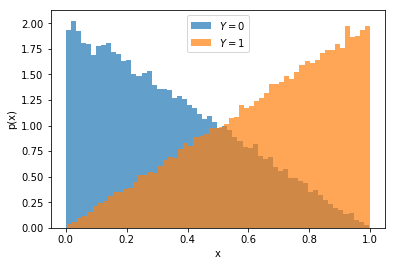

In [3]:
# Checking the distributions

features, labels = create_data(100000)

fig, ax = plt.subplots(1, 1)
ax.hist(features[labels == 0], normed=1, bins=60, alpha=0.7, label="$Y = 0$")
ax.hist(features[labels == 1], normed=1, bins=60, alpha=0.7, label="$Y = 1$")
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.legend()
plt.show()

You can see in the plot, that for $Y=0$ the distribution follows $p(x) = 2x - 2$ and for $Y = 1$ the distribution follows $p(x) = 2x$.

# 1.2 Classification by threshold

In [4]:
def thresh_rule_a(x, t):
    """
    This function returns the result (label) of rule A for a given t and x.
    """
    f = np.empty_like(x, dtype=int)
    f[x <= t] = 0
    f[x > t] = 1
    return f
    
def thresh_rule_b(x, t):
    """
    This function returns the result (label) of rule B for a given t and x.
    """
    f = np.empty_like(x, dtype=int)
    f[x <= t] = 1
    f[x > t] = 0
    return f
    
def analytic_error_rule_a(t):
    """
    This function returns the analytic error of rule A for a given t
    """
    return 1/4 + (t - 1/2)**2

def analytic_error_rule_b(t):
    """
    This function returns the analytic error of rule B for a given t
    """
    return 3/4 - (t - 1/2)**2


def calculate_error(decisions, labels):
    """
    This function calculates the error rate of the decisions with the real labels.
    """
    diff = decisions - labels
    return np.count_nonzero(diff)/labels.shape[0]

## Get error for different thresholds

In [5]:
for t in [0.2, 0.5, 0.6]:
    features, labels = create_data(10000)
    
    decision_a = thresh_rule_a(features, t)
    decision_b = thresh_rule_b(features, t)
    
    print('t = {:.1f}:'.format(t))
    print('\t p_err_a = {:.3f} (analytic: {:.3f})'.format(calculate_error(decision_a, labels), analytic_error_rule_a(t)))
    print('\t p_err_b = {:.3f} (analytic: {:.3f})'.format(calculate_error(decision_b, labels), analytic_error_rule_b(t)))

t = 0.2:
	 p_err_a = 0.345 (analytic: 0.340)
	 p_err_b = 0.655 (analytic: 0.660)
t = 0.5:
	 p_err_a = 0.255 (analytic: 0.250)
	 p_err_b = 0.745 (analytic: 0.750)
t = 0.6:
	 p_err_a = 0.259 (analytic: 0.260)
	 p_err_b = 0.741 (analytic: 0.740)


As you can see above, the best results are reached for $t = 0.5$ with decision rule A ($\approx 0.25$). The observations fit very well with the analytic results.

Now we want to see, how test set size influence the mean value and standard deviation of $p_{\text{error}}$. Therefore, we calculate $p_{\text{error}}$ for rule A with $t = 0.5$ 10 times to estimate the mean and standard-deviation. This is repeated for different test set sizes.

In [6]:
means = []
errors = []
ms = [10, 100, 1000, 10000, 100000]
for m in ms:
    test_results = []
    for _ in range(100):
        features, labels = create_data(m)
        decision_a = thresh_rule_a(features, 0.5)
        test_results.append(calculate_error(decision_a, labels))
    means.append(np.mean(test_results))
    errors.append(np.std(test_results))

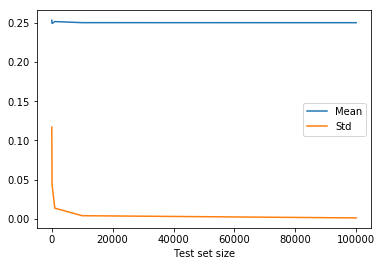

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(ms, means, label = "Mean")
ax.plot(ms, errors, label = "Std")

ax.set_xlabel('Test set size')
ax.legend()

plt.show()

As you can see in the plot, the mean value drops to $25\%$ already for a small test set size.
The standard deviation decreases towards $0$. The decay is quite rapid, for 20000 elements it is already negligable against the error for 10 elements ($\approx 15\%$).

# 1.3 Nearest Neighbour classifier

In [8]:
class NearestNeighbour1D:
    
    def __init__(self):
        self.training = {"features": [], "labels": []}
    
    def forget(self):
        self.training = {"features": [], "labels": []}
        
    def train(self, features, labels):
        self.training = {"features": features, "labels": labels}
    
    def classify(self, x):
        # get index of nearest neighbour
        ndx = np.argmin(np.abs(x - self.training["features"]))
        # return label of this guy
        return self.training["labels"][ndx]
    
    def test(self, features, labels):
        errors = 0
        for i in range(len(features)):
            result = self.classify(features[i])
            if result != labels[i]:
                errors += 1
        return errors/len(features)
            

In [9]:
# create a classifier
NN = NearestNeighbour1D()

error_rates = []

for _ in range(100):
    # reset this guy
    NN.forget()
    # create training set and train classifier
    training_features = [0, 0]
    training_labels = [0, 0]
    while training_labels[0] == training_labels[1]:
        training_features, training_labels = create_data(2)
        
    NN.train(training_features, training_labels)
    # create test set and test classifier
    test_features, test_labels = create_data(20000) # 20000 from above
    error_rates.append(NN.test(test_features, test_labels))
    
    

In [10]:
print('Average error rate: {:f}, Standarddeviation: {:f}'.format(np.mean(error_rates), np.std(error_rates)))

Average error rate: 0.339008, Standarddeviation: 0.159542


In the range of the standard deviation, the average fits to the expected value of $35\%$.